In [1]:
import numpy as np
import pandas as pd


In [2]:
data = pd.read_csv("Rice_data.csv")

In [3]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label,soil_moisture,soil_type,...,organic_matter,irrigation_frequency,crop_density,pest_pressure,fertilizer_usage,growth_stage,urban_area_proximity,water_source_type,frost_risk,water_usage_efficiency
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,29.446064,2,...,3.121395,4,11.743910,57.607308,188.194958,1,2.719614,3,95.649985,1.193293
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,12.851183,3,...,2.142021,4,16.797101,74.736879,70.963629,1,4.714427,2,77.265694,1.752672
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,29.363913,2,...,1.474974,1,12.654395,1.034478,191.976077,1,30.431736,2,18.192168,3.035541
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,26.207732,3,...,8.393907,1,10.864360,24.091888,55.761388,3,10.861071,3,82.818720,1.273341
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,28.236236,2,...,5.202285,3,13.852910,38.811481,185.259702,2,47.190777,3,25.466499,2.578671


In [4]:
rice_data = data.drop(['label','urban_area_proximity','frost_risk'], axis =1)

In [5]:
rice_data = rice_data.rename(columns={'temperature': 'T', 'humidity': 'H', 'soil_moisture': 'Soil_M', 'soil_type':'Soil_T','sunlight_exposure': 'Sun_E','wind_speed': 'W_S', 'co2_concentration':'CO2_CONC', 'organic_matter':'Organic_M','irrigation_frequency':'Irr_F','crop_density':'Crop_D', 'pest_pressure': 'Pest_Pr','fertilizer_usage':'Fert_U','growth_stage':'Growth_St','water_source_type':'Water_S','water_usage_efficiency':'Water_U_Eff'})


In [6]:
# State : Environmental and soil conditions 
state_col = ['T','H','ph','rainfall','Soil_M','Sun_E','W_S','CO2_CONC','Crop_D','Growth_St']

# Action : Parameter for the agent to control
action_col = ['Irr_F','Fert_U']

# Reward : Efficiency 
reward_col = ['Water_U_Eff']

In [7]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler

sc_state = MinMaxScaler()
sc_action = MinMaxScaler()
sc_reward = MinMaxScaler()

norm_state = sc_state.fit_transform(rice_data[state_col])
norm_action = sc_action.fit_transform(rice_data[action_col])
norm_reward = sc_reward.fit_transform(rice_data[reward_col])

# Combine normalized data into a DataFrame
norm_data = pd.DataFrame(norm_state, columns=state_col)
norm_data[action_col] = norm_action
norm_data['Water_U_Eff'] = norm_reward.flatten()

state_data = norm_data[state_col]
action_data = norm_data[action_col]

In [8]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from gym import spaces
from torch.distributions import Categorical

In [19]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class RiceEnv(gym.Env):
    def __init__(self, state_df, action_df, reward_series, reward_threshold):
        super(RiceEnv, self).__init__()

        self.state_df = state_df
        self.action_df = action_df
        self.reward_series = reward_series
        self.reward_threshold = reward_threshold
        self.current_step = 0

        # Define observation space (10 continuous features)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(10,), dtype=np.float32)

        # Define action space (2 discrete actions)
        self.action_space = spaces.Discrete(2)

    def reset(self):
        self.current_step = 0
        initial_state = self.state_df.iloc[self.current_step].values
        return initial_state

    def step(self, action):
        state = self.state_df.iloc[self.current_step].values
        base_reward = self.reward_series.iloc[self.current_step]

        # Define a penalty for each action
        penalty_for_action = 0
        if action == 0:  # Reducing water usage
            penalty_for_action = 0.1  
        elif action == 1:  # Reducing fertilizer usage
            penalty_for_action = 0.2  

        reward = base_reward - penalty_for_action

        self.current_step += 1
        done = self.current_step >= len(self.state_df)

        next_state = self.state_df.iloc[self.current_step].values if not done else np.zeros(10)
        return next_state, reward, done, {}


In [24]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)  
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  
        )

    def forward(self, state):
        action_probs = self.actor(state)
        state_value = self.critic(state)
        return action_probs, state_value

class A2CAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99):
        self.gamma = gamma
        self.model = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs, _ = self.model(state)
        action = torch.distributions.Categorical(action_probs).sample()
        return action.item()

    def train(self, env, num_episodes):
        episode_rewards = []
        for episode in range(num_episodes):
            state = env.reset()
            log_probs = []
            values = []
            rewards = []
            done = False

            while not done:
                state_tensor = torch.FloatTensor(state).to(torch.float32)  # Ensure float32
                action_probs, state_value = self.model(state_tensor)

                action_dist = torch.distributions.Categorical(action_probs)
                action = action_dist.sample()

                log_prob = action_dist.log_prob(action)
                next_state, reward, done, _ = env.step(action.item())

                log_probs.append(log_prob.unsqueeze(0))
                values.append(state_value)
                rewards.append(float(reward))  # Convert reward to float

                state = next_state

            # Compute returns
            returns = []
            discounted_sum = 0
            for reward in reversed(rewards):
                discounted_sum = reward + self.gamma * discounted_sum
                returns.insert(0, discounted_sum)

            # ✅ Convert all tensors to `float32`
            returns = torch.tensor(returns, dtype=torch.float32)
            values = torch.cat(values).to(torch.float32)
            log_probs = torch.cat(log_probs).to(torch.float32)

            advantages = returns - values.squeeze()
            actor_loss = -(log_probs * advantages.detach()).mean()
            critic_loss = self.loss_fn(values.squeeze(), returns)

            loss = actor_loss + critic_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            episode_rewards.append(sum(rewards))

            if episode % 100 == 0:
                print(f"Episode {episode}, Total Reward: {sum(rewards):.2f}")

        return episode_rewards



Episode 0, Total Reward: 763.25
Episode 100, Total Reward: 752.55
Episode 200, Total Reward: 817.55
Episode 300, Total Reward: 830.25
Episode 400, Total Reward: 852.05
Episode 500, Total Reward: 862.35
Episode 600, Total Reward: 865.65
Episode 700, Total Reward: 869.55
Episode 800, Total Reward: 869.05
Episode 900, Total Reward: 869.15
Episode 1000, Total Reward: 869.65
Episode 1100, Total Reward: 872.65
Episode 1200, Total Reward: 872.95
Episode 1300, Total Reward: 873.25
Episode 1400, Total Reward: 873.45
Episode 1500, Total Reward: 874.25
Episode 1600, Total Reward: 874.15
Episode 1700, Total Reward: 873.85
Episode 1800, Total Reward: 874.65
Episode 1900, Total Reward: 874.25


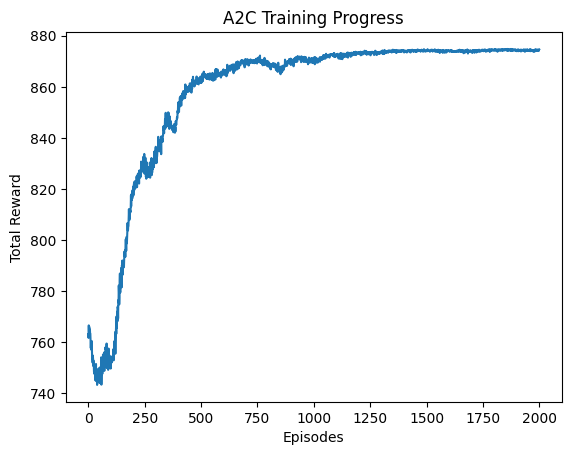

In [25]:
# Normalize the data (Already provided by you)
state_df = norm_data[state_col]
action_df = norm_data[action_col]
reward_series = norm_data['Water_U_Eff']
reward_threshold = 0.5  # Adjust threshold as needed

# Initialize environment
env = RiceEnv(state_df, action_df, reward_series, reward_threshold)

# Initialize and Train A2C
state_dim = len(state_col)  
action_dim = 2  
a2c_agent = A2CAgent(state_dim, action_dim, lr=0.001, gamma=0.99)

num_episodes = 2000
episode_rewards = a2c_agent.train(env, num_episodes)

# Plot training rewards
plt.plot(episode_rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("A2C Training Progress")
plt.show()


In [26]:
state = env.reset()
done = False

while not done:
    action = a2c_agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    print(f"Action: {action}, Reward: {reward}")
    state = next_state


Action: 0, Reward: -0.052143723191626606
Action: 0, Reward: 0.08787505601735354
Action: 0, Reward: 0.4089918599633212
Action: 0, Reward: -0.03210696056545145
Action: 0, Reward: 0.2946321126889875
Action: 0, Reward: 0.0881113462828659
Action: 0, Reward: 0.44302747641996854
Action: 0, Reward: 0.44503608868606503
Action: 0, Reward: 0.03238312332550794
Action: 0, Reward: 0.7973036795268461
Action: 0, Reward: 0.018633290895307603
Action: 0, Reward: 0.8897825826175626
Action: 0, Reward: 0.04191153916556542
Action: 0, Reward: -0.093083781007028
Action: 0, Reward: 0.7531655359973507
Action: 0, Reward: -0.0067697074181519434
Action: 0, Reward: -0.0665040082055324
Action: 0, Reward: -0.0791091191166978
Action: 0, Reward: 0.22241914839487023
Action: 0, Reward: -0.023532898890537696
Action: 0, Reward: 0.017146311949057108
Action: 1, Reward: 0.4683829279839335
Action: 0, Reward: 0.26634077447104143
Action: 0, Reward: 0.32171591137226196
Action: 0, Reward: 0.30730866272567847
Action: 0, Reward: 0.64

In [29]:
# Save the trained model
torch.save(a2c_agent.model.state_dict(), "a2c_rice_model.pth")

# Load the trained model
a2c_agent.model.load_state_dict(torch.load("a2c_rice_model.pth"))
a2c_agent.model.eval()


ActorCritic(
  (actor): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
    (3): Softmax(dim=-1)
  )
  (critic): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [34]:
optimized_actions = a2c_agent.model(state_tensor)
optimized_actions


(tensor([[9.9942e-01, 5.8309e-04],
         [9.9736e-01, 2.6418e-03],
         [9.9917e-01, 8.2610e-04],
         ...,
         [9.9933e-01, 6.6880e-04],
         [9.9854e-01, 1.4641e-03],
         [9.9956e-01, 4.4185e-04]], grad_fn=<SoftmaxBackward>),
 tensor([[36.4212],
         [34.3249],
         [36.4535],
         ...,
         [35.3388],
         [36.9676],
         [36.0898]], grad_fn=<AddmmBackward>))

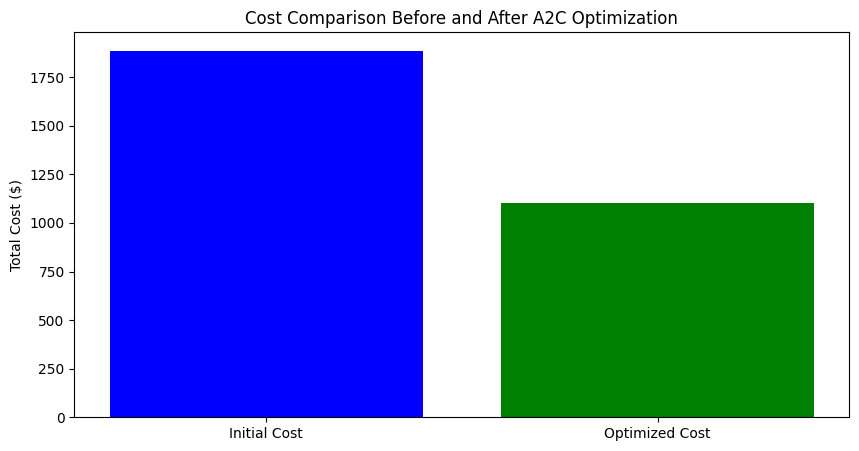

Initial Cost: $1886.53
Optimized Cost: $1103.50
Total Savings: $783.03


In [35]:
# Define cost per unit
water_cost_per_unit = 0.5
fertilizer_cost_per_unit = 1.2

# Initial Costs
initial_water_usage = norm_data['Irr_F']
initial_fertilizer_usage = norm_data['Fert_U']
initial_water_cost = initial_water_usage * water_cost_per_unit
initial_fertilizer_cost = initial_fertilizer_usage * fertilizer_cost_per_unit
initial_total_cost = initial_water_cost + initial_fertilizer_cost

# New Costs After Optimization
optimized_water_cost = optimized_water_usage * water_cost_per_unit
optimized_fertilizer_cost = optimized_fertilizer_usage * fertilizer_cost_per_unit
optimized_total_cost = optimized_water_cost + optimized_fertilizer_cost

# Plot Cost Comparison
plt.figure(figsize=(10, 5))
plt.bar(['Initial Cost', 'Optimized Cost'], [initial_total_cost.sum(), optimized_total_cost.sum()], color=['blue', 'green'])
plt.title('Cost Comparison Before and After A2C Optimization')
plt.ylabel('Total Cost ($)')
plt.show()

print(f"Initial Cost: ${initial_total_cost.sum():.2f}")
print(f"Optimized Cost: ${optimized_total_cost.sum():.2f}")
print(f"Total Savings: ${initial_total_cost.sum() - optimized_total_cost.sum():.2f}")
